In [5]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM_ import RTRBM as RTRBM_
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *
%matplotlib inline


Minimum connectivity is: tensor(0.3333)
tensor(200) tensor([5.9605e-09, 4.7684e-09, 2.0862e-09]) tensor([0.6356, 0.6435, 0.4020])


<AxesSubplot:>

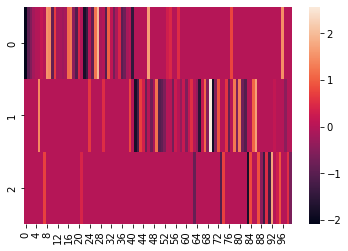

In [16]:
# TODO fix norm of matrix to be ~0
N_H, N_V = 3, 100
nabla = 2
connectivity = 0
rand_assign = 0.3

## initialize parameters
sparcity = 1 - connectivity

sp = 1 - 1/N_H

if N_H==N_V:
        W = torch.eye(N_H) * nabla * torch.randn((N_H, N_V), dtype=torch.float)
        W = W[torch.randperm(N_H), :]
else:
    # initialze fully connected random weight matrix
    W = nabla * torch.zeros((N_H, N_V), dtype=torch.float)

    # Assign random sized populations to each N_H (how many connections has each N_H at connectivity=minimum connectivity)
    chunks = N_V * torch.ones(N_H - 1)
    while torch.sum(chunks) > N_V:
        chunks = torch.randint(low=int(0.5 * (N_V/N_H)), high=int(1.5 * (N_V/N_H)), size=(N_H-1,))
    chunks = torch.cat([torch.tensor([0]), torch.cat([chunks, torch.tensor([N_V - torch.sum(chunks)])])])

    # Randomly assign N_V idx to each HU population (randomly can be changed with rand_assign)
    temp = torch.arange(N_V)
    rand_idx = torch.randperm(N_V)[:int(N_V * rand_assign)]
    temp[rand_idx] = rand_idx[torch.randperm(rand_idx.shape[0])]
    randperm = [ temp[torch.sum(chunks[:h+1]) : chunks[h+1] + torch.sum(chunks[:h+1])] for h in range(N_H)]

    for h in range(N_H):
        W[h, randperm[h]] = nabla * torch.randn(size=randperm[h].shape, dtype=torch.float)

# compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
sp = torch.sum(W==0)/W.numel()
conn = 1 - sp
n_zeros = int(torch.sum(W==0) - sparcity * W.numel())

if n_zeros>0:
    # randomly add values to the weight matrix in order to obtain the predefined connectivity
    idx = torch.where(W.ravel() == 0)[0]
    idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
    W.ravel()[idx] = nabla * torch.randn(n_zeros, dtype=torch.float)
else:
    print('Minimum connectivity is: '+str(conn))

for i in range(N_H):
    idx = W[i, :] != 0
    if torch.sum(idx)>1:
        W[i, idx] = (W[i, idx] - torch.mean(W[i, idx])) / torch.std(W[i, idx])

print(torch.sum(W == 0), torch.mean(W, 1), torch.std(W,1))
sns.heatmap(W)

In [9]:
def gen_W(N_H, N_V, nabla=2, connectivity=0, rand_assign=1, size_chunk=[0.5, 1.5]):
    ## initialize parameters
    sparcity = 1 - connectivity

    sp = 1 - 1/N_H

    if N_H==N_V:
            W = torch.eye(N_H) * nabla * torch.randn((N_H, N_V), dtype=torch.float)
            W = W[torch.randperm(N_H), :]
    else:
        # initialze fully connected random weight matrix
        W = nabla * torch.zeros((N_H, N_V), dtype=torch.float)

        # Assign random sized populations to each N_H (how many connections has each N_H at connectivity=minimum connectivity)
        chunks = N_V * torch.ones(N_H - 1)
        while torch.sum(chunks) > N_V:
            if size_chunk[0] == size_chunk[1]:
                chunks = (N_V//N_H * torch.ones(N_H - 1)).to(torch.int16)
            else:
                chunks = torch.randint(low=int(size_chunk[0] * (N_V/N_H)), high=int(size_chunk[1] * (N_V/N_H)), size=(N_H-1,))
        chunks = torch.cat([torch.tensor([0]), torch.cat([chunks, torch.tensor([N_V - torch.sum(chunks)])])])

        # Randomly assign N_V idx to each HU population (randomly can be changed with rand_assign)
        temp = torch.arange(N_V)
        rand_idx = torch.randperm(N_V)[:int(N_V * rand_assign)]
        temp[rand_idx] = rand_idx[torch.randperm(rand_idx.shape[0])]
        randperm = [ temp[torch.sum(chunks[:h+1]) : chunks[h+1] + torch.sum(chunks[:h+1])] for h in range(N_H)]

        for h in range(N_H):
            W[h, randperm[h]] = nabla * torch.randn(size=randperm[h].shape, dtype=torch.float)

    # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
    sp = torch.sum(W==0)/W.numel()
    conn = 1 - sp
    n_zeros = int(torch.sum(W==0) - sparcity * W.numel())

    if n_zeros>0:
        # randomly add values to the weight matrix in order to obtain the predefined connectivity
        idx = torch.where(W.ravel() == 0)[0]
        idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
        W.ravel()[idx] = nabla * torch.randn(n_zeros, dtype=torch.float)
    else:
        print('Minimum connectivity is: '+str(conn))

    for i in range(N_H):
        idx = W[i, :] != 0
        if torch.sum(idx)>1:
            W[i, idx] = (W[i, idx] - torch.mean(W[i, idx])) / torch.std(W[i, idx])

    return W

In [107]:
N_H, N_V = 4, 100
W = gen_W(N_H=N_H, N_V=N_V, nabla=1, connectivity=0, rand_assign=0, size_chunk=[1,1])
# W[W>0] = 4
# W[W<0] = -4

Minimum connectivity is: tensor(0.2500)


In [110]:
## initialize parameters
N_H, N_V = 3, 100
nabla = 2
connectivity = 0
rand_assign = 0.3
sparcity = 1 - connectivity
sp = 1 - 1/N_H

W_norm = torch.sum(W, 1)
W_norm

tensor([ 1.1921e-07, -5.9605e-08, -1.1921e-07, -2.9802e-08])

In [ ]:
U = torch.eye(N_H) * nabla * torch.randn((N_H, N_H), dtype=torch.float)
U = U[torch.randperm(N_H), :]


Minimum connectivity is: tensor(0.2500)


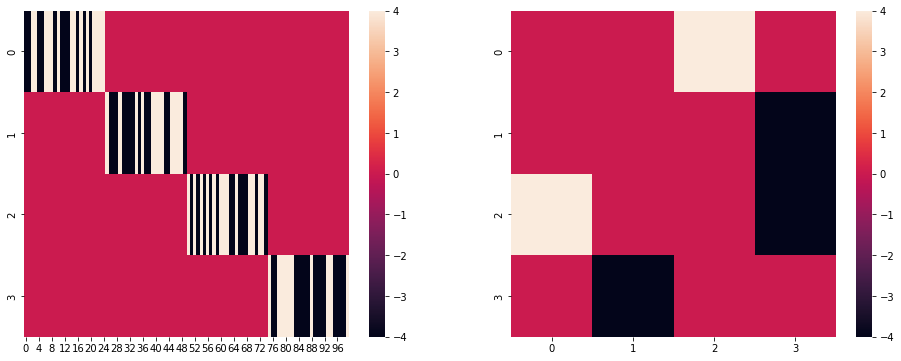

C:\Users\sebas\AppData\Local\Temp/ipykernel_12144/2572291070.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float, device='cpu')


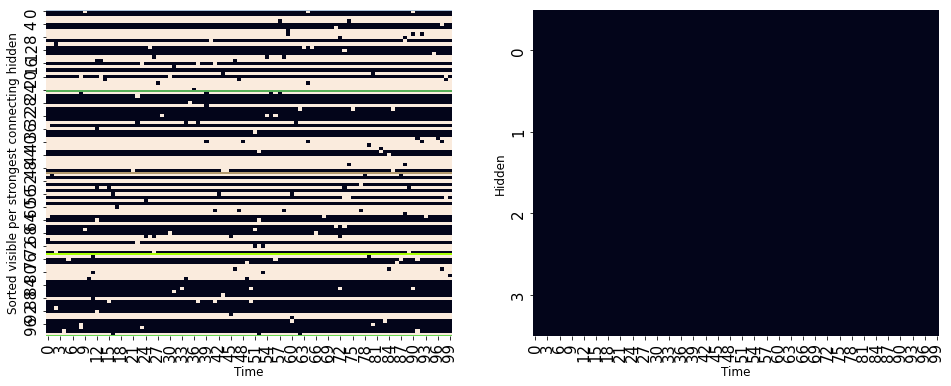

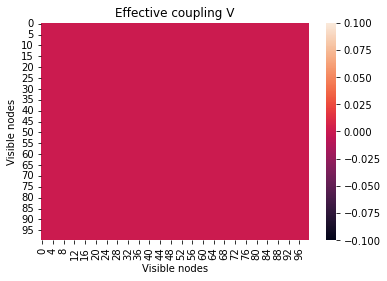

In [14]:
N_H, N_V = 4, 100
W = gen_W(N_H=N_H, N_V=N_V, nabla=1, connectivity=0, rand_assign=0, size_chunk=[1,1])
W[W>0] = 4
W[W<0] = -4

U = gen_W(N_H=N_H, N_V=N_H, nabla=1, connectivity=0.35, rand_assign=0)
U[U>0 ] = 4
U[U<0 ] = -4

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(W, ax=ax[0])
sns.heatmap(U, ax=ax[1])
plt.show()

# Initialize rtrbm
T = 100

rtrbm_init = RTRBM(torch.zeros(N_V, T), N_H=N_H, device='cpu')
rtrbm_init.W = W
rtrbm_init.U = U
rtrbm_init.b_H = torch.zeros(1, N_H, dtype=torch.float)
rtrbm_init.b_V = torch.zeros(1, N_V, dtype=torch.float)
rtrbm_init.b_init = torch.zeros(1, N_H, dtype=torch.float)



n_batches = 1
data = torch.zeros(N_V, T, n_batches)
rt = torch.zeros(N_H, T, n_batches)
for batch in range(n_batches):
    v_start = (torch.rand(N_V) > 0.7)*1.0
    data[:, :, batch], rt[:, :, batch] = rtrbm_init.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
data = torch.tensor(data, dtype=torch.float, device='cpu')
idx = plot_spikes_grouped_by_HU(W, data[:, :, 0].cpu(), rt[:, :, 0].cpu())

# variance matrix
var_h_matrix = torch.reshape(torch.var(rt[:, :, 0], 1).repeat(W.shape[1]), [W.shape[1], W.shape[0]]).T

# effective coupling W
Je_W = torch.mm(W[:, idx].T, W[:, idx] * var_h_matrix)/W.shape[1]**2

sns.heatmap(Je_W)
plt.ylabel("Visible nodes")
plt.xlabel("Visible nodes")
plt.title('Effective coupling V')
plt.tick_params(axis='both', which='major')

In [101]:
torch.sum(W, 1)

tensor([12., 12., -4., -4.])

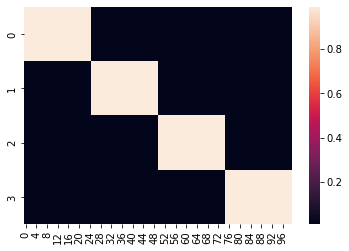

tensor([[ 4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,
          4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,
          4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,  4.5951,
          4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951, -4.5951,
         -4.5951, -4.5951, -

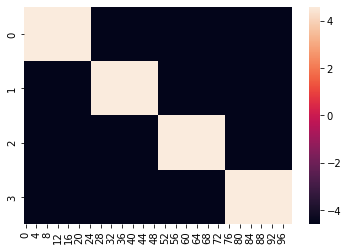

In [95]:
test_trace = 0.01 * torch.ones(N_H, N_V)
test_trace[0, :25] = 0.99
test_trace[1, 25:50] = 0.99
test_trace[2, 50:75] = 0.99
test_trace[3, 75:100] = 0.99
sns.heatmap(test_trace)
plt.show()
sns.heatmap(torch.log(test_trace/(1-test_trace)))
x = torch.log(test_trace/(1-test_trace))
x

In [13]:
def plot_spikes_grouped_by_HU(W, vt, rt, fontsize=12):
    # W.shape = [H, V]

    colors_list = list(colors._colors_full_map.values())
    N_V, T = vt.shape
    N_H = rt.shape[0]
    stongest_connecting_HU = torch.zeros(N_V)

    for i in range(N_V):
        # returns the index of the strongest connecting HU per visible, according to W
        stongest_connecting_HU[i] = torch.argmax(torch.abs(W[:, i]))

    # sort visibles to their strongest connection HU
    idx = torch.argsort(stongest_connecting_HU)
    num = torch.zeros(N_H+1, dtype=int)
    for i in range(N_H):
        # determine how many visibles are connected to hidden i
        num[i+1] = num[i] + torch.count_nonzero(stongest_connecting_HU == i)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(vt[idx,:], ax = ax[0], cbar=False)
    ax[0].set_xlabel('Time', fontsize=fontsize)
    ax[0].set_ylabel('Sorted visible per strongest connecting hidden', fontsize=fontsize)
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    for x, i in enumerate(num):
        ax[0].hlines(i, 0, T, colors = colors_list[x], linewidth=2)

    sns.heatmap(rt, ax = ax[1], cbar=False)
    ax[1].set_xlabel('Time', fontsize=fontsize)
    ax[1].set_ylabel('Hidden', fontsize=fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=15)

    plt.show()
    return idx

In [5]:
def reshuffle(W_original, W_train, U_original, U_train):

    corr = np.zeros((N_H, N_H))
    shuffle_idx = np.zeros((N_H))
    for i in range(N_H):
        for j in range(N_H):
            corr[i, j] = np.correlate(W_original[i,:], W_train[j,:])
        shuffle_idx[i] = np.argmax(corr[i,:])

    W_train = W_train[shuffle_idx, :]
    U_train = U_train[shuffle_idx, :]
    U_train = U_train[:, shuffle_idx]

    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    ax[0].scatter(W_original.ravel(), W_train.ravel())
    ax[0].set_xlabel('Original')
    ax[0].set_ylabel('Trained')
    ax[0].set_title('r-value:'+str(r_W))
    ax[1].scatter(U_original.ravel(), U_train.ravel())
    ax[1].set_xlabel('Original')
    ax[1].set_ylabel('Trained')
    ax[1].set_title('r-value:'+str(r_U))

    return W_original, W_train, U_original, U_train

In [6]:
def gen_weights1(N_H, N_V, nabla=2, connectivity=0):
    ## initialize parameters
    sparcity = 1 - connectivity

    sp = 1 - 1/N_H

    if N_H==N_V:
        W = torch.eye(N_H) * nabla * torch.randn((N_H, N_V), dtype=torch.float)
        W = W[torch.randperm(N_H), :]

    else:
        # initialze fully connected random weight matrix
        W = nabla * torch.randn((N_H, N_V), dtype=torch.float)

        # Make the weight matrix sparse such that only 1 visible is randomly connected to 1 hidden
        for i, idx in enumerate(torch.randperm(N_V)):
            if torch.sum(W[:, idx]==0)/N_H<sp:
                W[:, idx][np.random.permutation(N_H)[:int(np.ceil(sp * N_H))]] = 0

    # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
    sp = torch.sum(W==0)/W.numel()
    conn = 1 - sp
    n_zeros = int(torch.sum(W==0) - sparcity * W.numel())
    if n_zeros>0:
        # randomly add values to the weight matrix in order to obtain the predefined connectivity
        idx = torch.where(W.ravel() == 0)[0]
        idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
        W.ravel()[idx] = nabla * torch.randn(n_zeros, dtype=torch.float)
    else:
        print('Minimum connectivity is: '+str(conn))
    # sp = torch.sum(W==0)/W.numel()
    # conn = 1 - sp

    for i in range(N_H):
        idx = W[i, :] != 0
        if torch.sum(idx)>1:
            W[i, idx] = (W[i, idx] - torch.mean(W[i, idx])) / torch.std(W[i, idx])
    return W


In [ ]:
# learning parameters
n_epochs = int(1000)
lr = 1e-3
SP = [0, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
params = [rtrbm_init.W, rtrbm_init.U, rtrbm_init.b_H, rtrbm_init.b_V, rtrbm_init.b_init]

for sp in SP:
    # Weights & sparcity
    W = torch.zeros([N_H, N_V, n_epochs])
    U = torch.zeros([N_H, N_H, n_epochs])
    sparcity = torch.zeros(n_epochs)
    sparcity_true = torch.sum(torch.abs(rtrbm_init.W) < 1e-3) / (N_H*N_V)

    Dparams = [torch.zeros_like(param, dtype=torch.float, device='cpu') for param in params]
    rtrbm = RTRBM_nobias(data, N_H=N_H, device='cpu')
    error = torch.zeros(n_epochs)

    for epoch in tqdm(range(n_epochs)):
        rtrbm.learn(n_epochs=1, batchsize=10, CDk=10, lr=lr, mom=0.9, wc=0.0002, sp=sp, x=2, Dparams=Dparams, disable_tqdm=True)
        Dparams = rtrbm.Dparams
        error[epoch] = rtrbm.errors

        W[:, :, epoch] = rtrbm.W
        U[:, :, epoch] = rtrbm.U
        sparcity[epoch] = torch.sum(torch.abs(W[:, :, epoch]) < 1e-3) / (N_H*N_V)


    scalability = [rtrbm, rtrbm_init, W, U, error]
    torch.save(scalability, open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Sampling rate\scalability reproducing rtrbm sparse\scalability_06_sp'+"{:.0e}".format(sp), 'wb'))


<IPython.core.display.Javascript object>


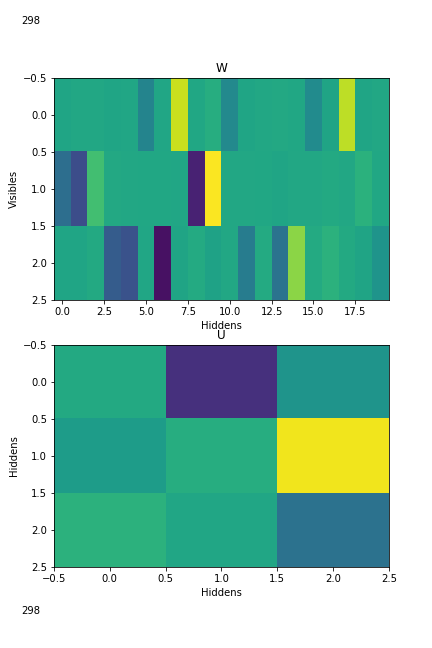

In [18]:
import matplotlib.animation as animation
%matplotlib notebook

n_epochs = W.shape[2]

snapshots_W = [W[:, :, i] for i in range(n_epochs)]
snapshots_U = [U[:, :, i] for i in range(n_epochs)]

# plt.clf()
fig, axes = plt.subplots(2, 1, figsize=(6, 9))
im_W = axes[0].imshow(snapshots_W[0], interpolation='none', aspect='auto',
                       vmin=W.ravel().min(), vmax=W.ravel().max())
im_U = axes[1].imshow(snapshots_U[0], interpolation='none', aspect='auto',
                       vmin=W.ravel().min(), vmax=W.ravel().max())

# add another axes at the top left corner of the figure
axtext = fig.add_axes([0.0, 0.95, 0.1, 0.05])
# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5, 0.5, str(0), ha="left", va="top")
time1 = axtext.text(0.5, -18, str(0), ha="left", va="bottom")

axes[0].set_xlabel('Hiddens')
axes[0].set_ylabel('Visibles')
axes[0].set_title('W')

axes[1].set_xlabel('Hiddens')
axes[1].set_ylabel('Hiddens')
axes[1].set_title('U')
def animate_func(i):
    im_W.set_array(snapshots_W[i])
    im_U.set_array(snapshots_U[i])
    time.set_text(str(i))
    time1.set_text(str(i))
    return [im_W, im_U, time, time1]

ani = animation.FuncAnimation(
    fig,
    animate_func,
    frames=n_epochs,
    interval=1,  # in ms
    blit=False)

plt.show()

<IPython.core.display.Javascript object>


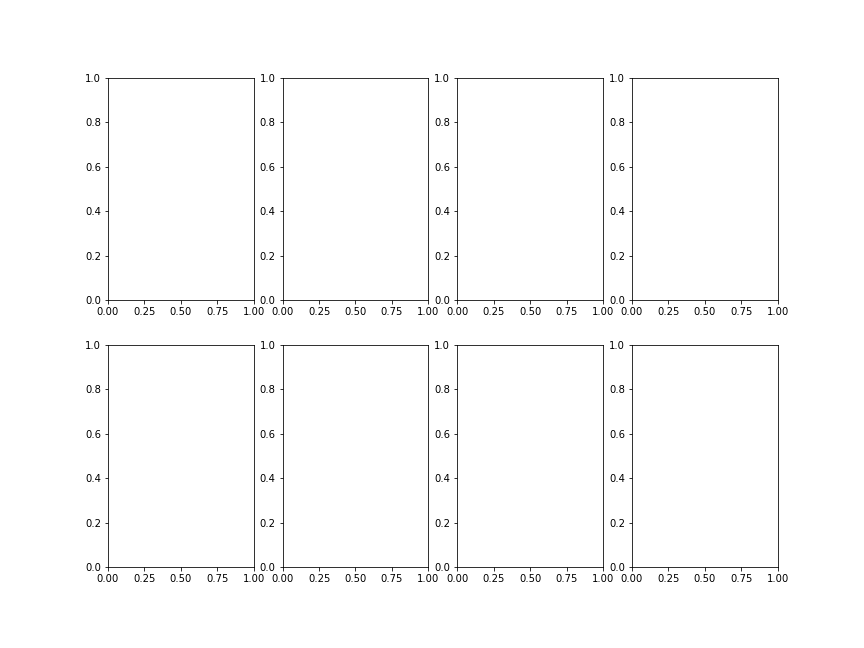

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9))

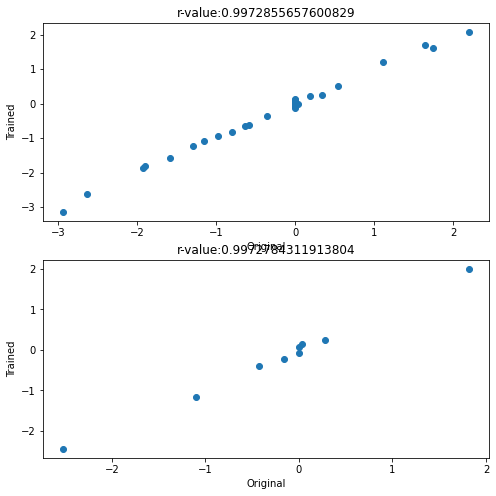

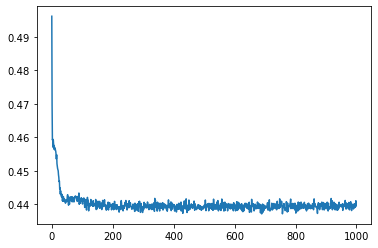

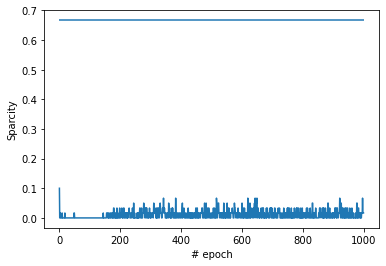

In [33]:
W_original = rtrbm_init.W.detach().clone()
W_train = rtrbm.W.detach().clone()
U_original = rtrbm_init.U.detach().clone()
U_train = rtrbm.U.detach().clone()
W_original, W_train, U_original, U_train, r_W, r_U = reshuffle(W_original, W_train, U_original, U_train)
plt.show()
plt.plot(error)
plt.show()
plot_weights_true_reconstructed(W_original, U_original, W_train, U_train)
plt.show()
plt.plot(sparcity)
plt.xlabel('# epoch')
plt.ylabel('Sparcity')
plt.hlines(sparcity_true, 0, n_epochs)


In [ ]:
temp = sparcity - sparcity_true
zero_crossings = np.where(np.diff(np.sign(temp)))[0]
freq = zero_crossings / n_epochs

100%|██████████| 1000/1000 [22:53<00:00,  1.37s/it]


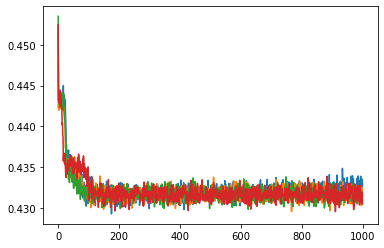

In [47]:
for sp in [1e-7, 1e-8, 1e-9, 1e-10]:#[0, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    rtrbm = RTRBM_nobias(data, N_H=N_H, device='cpu')
    rtrbm.learn(n_epochs=1000, batchsize=10, CDk=10, lr=1e-3, lr_end=1e-5, start_decay=100, \
                mom=0.9, wc=0.0002, sp=sp, x=2)
    plt.plot(rtrbm.errors)
    torch.save(rtrbm, open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Reproduce_rtrbm\sparcity\rtrbm_sp_'+str(sp), 'wb'))

In [ ]:
torch.save(rtrbm, open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Reproduce_rtrbm\sparcity', 'wb'))

In [ ]:
def reshuffle(W_original, W_train, U_original, U_train):

    corr = np.zeros((N_H, N_H))
    shuffle_idx = np.zeros((N_H))
    for i in range(N_H):
        for j in range(N_H):
            corr[i, j] = np.correlate(W_original[i,:], W_train[j,:])
        shuffle_idx[i] = np.argmax(corr[i,:])

    W_train = W_train[shuffle_idx, :]
    U_train = U_train[shuffle_idx, :]
    U_train = U_train[:, shuffle_idx]

    _, _, r_W, _, _ = linregress(W_original.ravel(), W_train.ravel())
    _, _, r_U, _, _ = linregress(U_original.ravel(), U_train.ravel())

    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    ax[0].scatter(W_original.ravel(), W_train.ravel())
    ax[0].set_xlabel('Original')
    ax[0].set_ylabel('Trained')
    ax[0].set_title('r-value:'+str(r_W))
    ax[1].scatter(U_original.ravel(), U_train.ravel())
    ax[1].set_xlabel('Original')
    ax[1].set_ylabel('Trained')
    ax[1].set_title('r-value:'+str(r_U))

    return W_original, W_train, U_original, U_train, r_W, r_U

In [109]:

### THE NETHERLANDS

# (number of total returns (23 * 10e6) *
# percentage returns of clothing (0.4) *
# average cost of one return (12.5) *
# return caused by fit mismatch (0.5) *
# Effectiveness of app on returned clothes caused by mismatch (0.1)
23 * 10e6 * 0.4 * 12.5 * 0.5 * 0.1


57500000.0

In [126]:
1e5 / ((23e6 * 0.4) / 18000 * 12.5 * 0.5 * 0.1)


313.04347826086956